In [8]:
from jax import random, jit, vmap
from functions.simulation import get_dataset, get_epsilon_star
from functions.training import train_loop
from functions.simulation import ABC_epsilon
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative
import jax.numpy as jnp
import time
import pickle 
import lzma
import numpy as np
import scipy.stats as stats
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return jnp.sort(random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return ((jnp.mean(y)-jnp.mean(y_true))**2)

key = random.PRNGKey(0)


MU0, SIGMA0 = 0., 20.
PRIOR_ARGS = [MU0, SIGMA0]

SIGMA = 1.
MODEL_ARGS = [SIGMA]

from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)


N_DATA = 1
TRUE_MU = 20.
TRUE_DATA = data_simulator(key, TRUE_MU)

In [9]:
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def delta(x):
    return 1

def sample_biased_post(key, z, L):
    key_sim, key_noise = random.split(key)
    delta = .01
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(z))/(SIGMA0**2*len(z) + SIGMA**2) + delta*z
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return random.normal(key_sim, (L,))*jnp.sqrt(sigma2_post) + mu_post

sample_biased_post = jit(sample_biased_post, static_argnums = 2)
def SBC_biased_epsilon(key, N_SBC, L, epsilon, true_data, prior_simulator, data_simulator, discrepancy):
    datas, thetas_tilde, _, key = ABC_epsilon(key, N_SBC, prior_simulator, data_simulator, discrepancy, epsilon, true_data)
    key, sampling_key = random.split(key)
    sampling_keys = random.split(sampling_key, N_SBC)
    thetas = (vmap(sample_biased_post, in_axes = (0, 0, None)))(sampling_keys, datas, L)
    ranks = jnp.sum(thetas < thetas_tilde, axis = 1)
    return ranks, thetas_tilde, thetas, key

In [3]:
PRIOR = stats.norm(loc = MU0, scale = SIGMA0)

In [10]:
L = 127
B = 32
N_SBC = (L+1)*100
EPSILON = jnp.inf
EPSILONS = []
ACCEPT_RATES = [1., .999, .99, .975, .95, .925, .9, .85,.8,.75]
for ACCEPT_RATE in ACCEPT_RATES:
    print(f"\n\n---------\nACCEPT RATE = {ACCEPT_RATE:.2%}\n---------\n")
    EPSILON, key = get_epsilon_star(key, ACCEPT_RATE, 1000, prior_simulator, data_simulator, discrepancy, TRUE_DATA, .95, EPSILON)
    EPSILONS.append(EPSILON)
    

    



---------
ACCEPT RATE = 100.00%
---------

Distances: min =  0.00015847036 max =  7230.045 mean =  786.20166 std =  997.75757


---------
ACCEPT RATE = 99.90%
---------

Distances: min =  0.00043580448 max =  6744.2964 mean =  784.4736 std =  977.0152
epsilon:  2731.177490234375 acceptance rate:  0.998


---------
ACCEPT RATE = 99.00%
---------

epsilon:  2178.037109375 acceptance rate:  0.99200004
epsilon:  1809.37646484375 acceptance rate:  0.99500006
epsilon:  1479.845703125 acceptance rate:  0.98600006


---------
ACCEPT RATE = 97.50%
---------

epsilon:  1258.531494140625 acceptance rate:  0.98600006
epsilon:  1053.53955078125 acceptance rate:  0.99100006
epsilon:  924.01708984375 acceptance rate:  0.98800004
epsilon:  809.3766479492188 acceptance rate:  0.97800004
epsilon:  721.6699829101562 acceptance rate:  0.9760001
epsilon:  654.5112915039062 acceptance rate:  0.97700006
epsilon:  583.416748046875 acceptance rate:  0.98
epsilon:  517.4014282226562 acceptance rate:  0.977000

In [ ]:
find_grid_explorative()

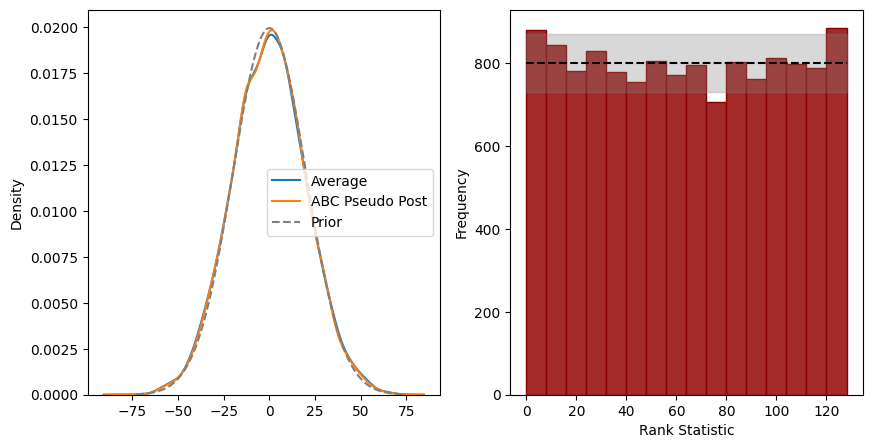

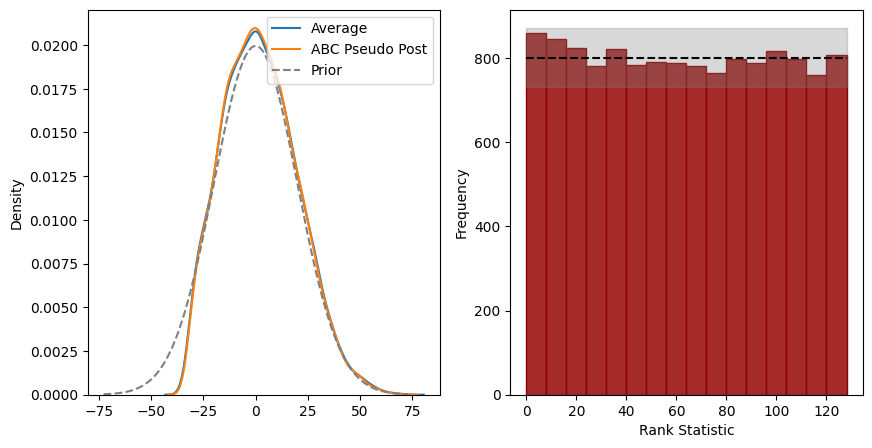

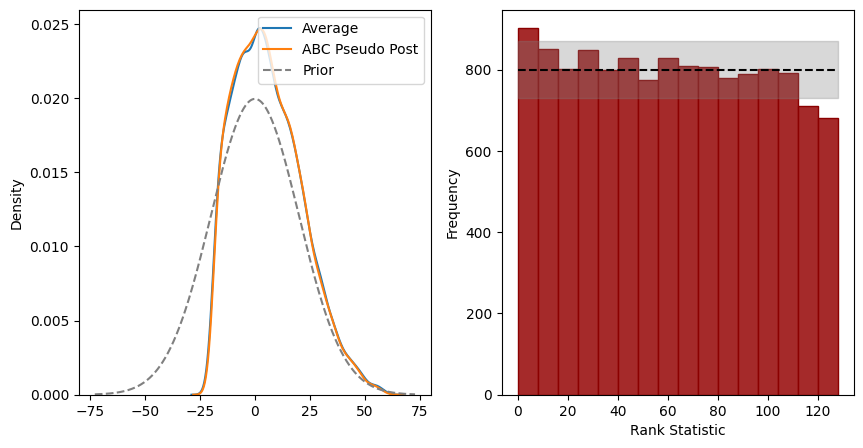

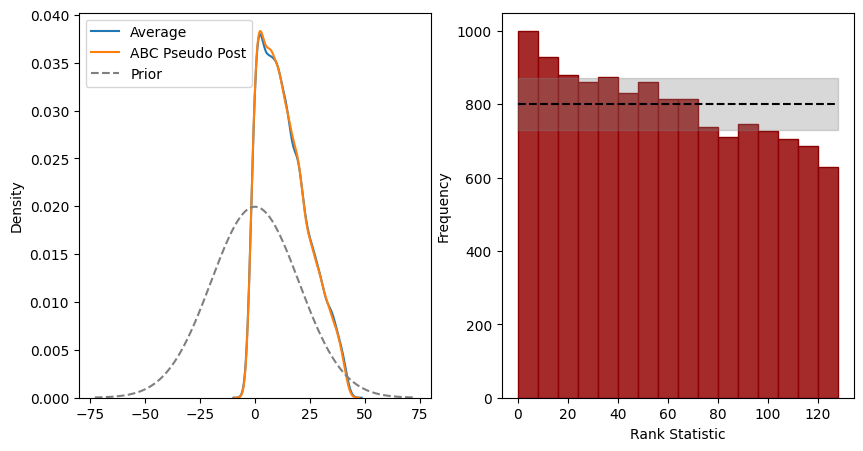

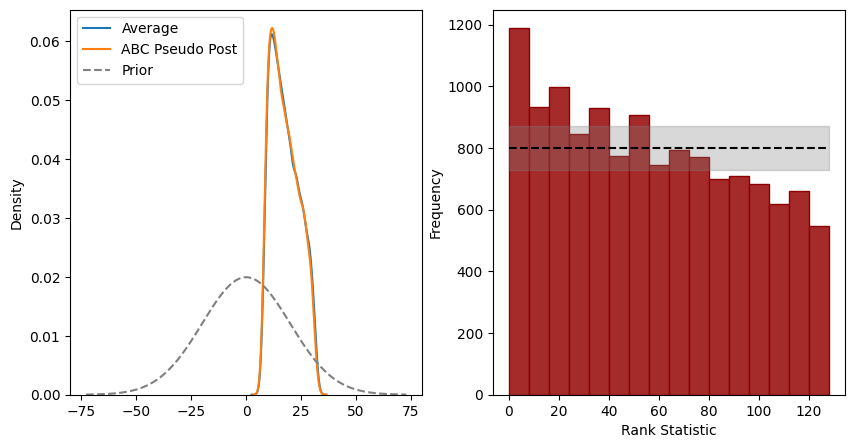

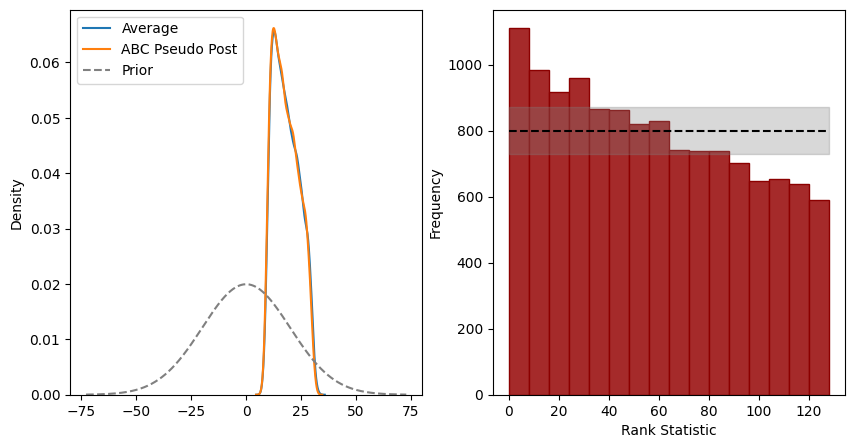

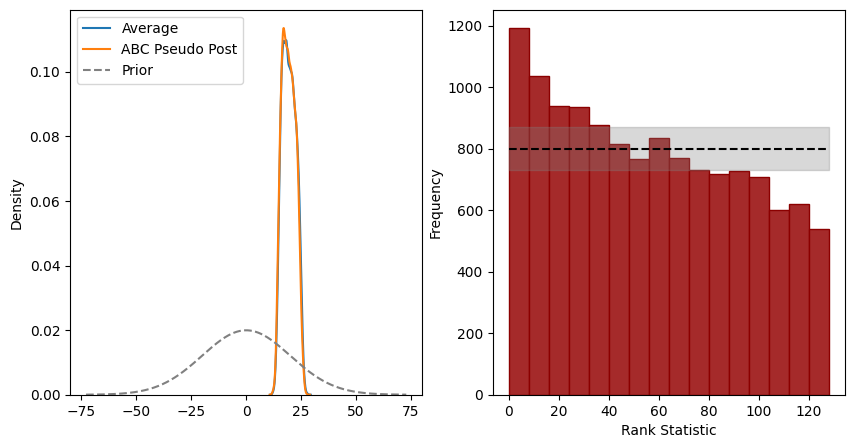

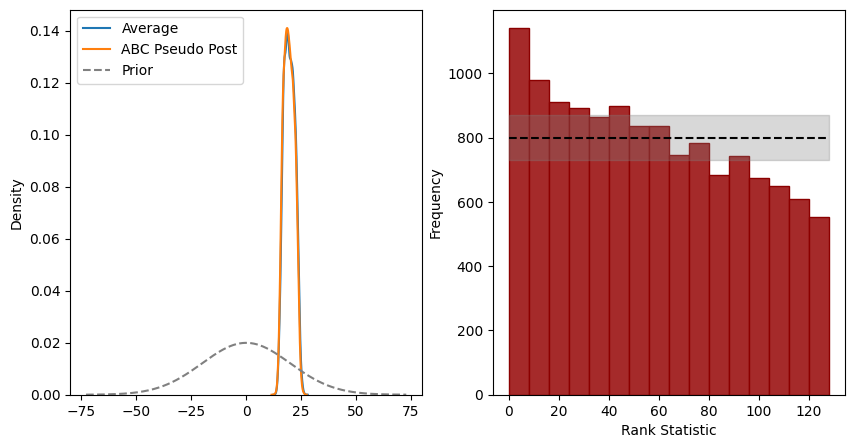

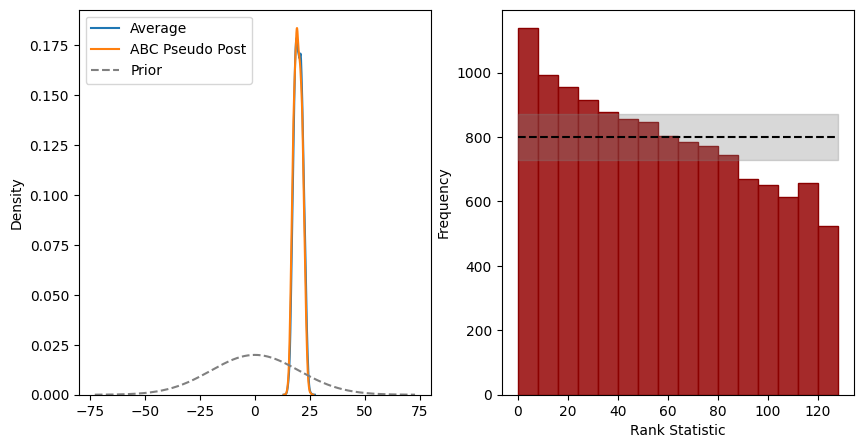

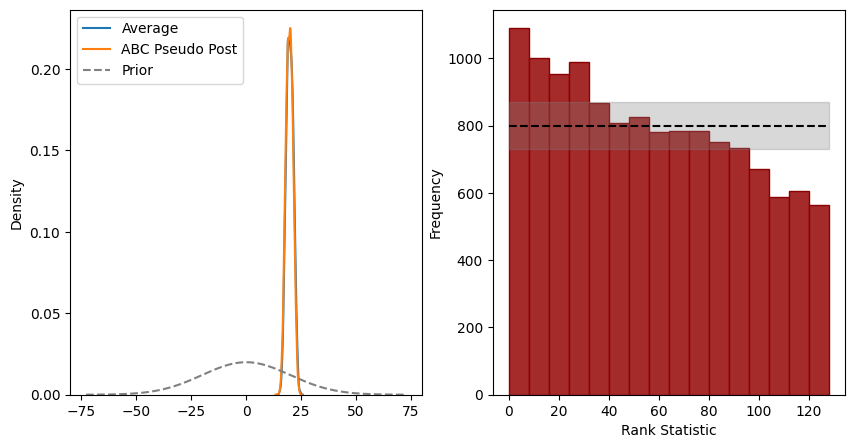

In [11]:
grid_prior, pdf_prior = find_grid_explorative(lambda x: PRIOR.pdf(x), 10000, 10000, -50, 50)
B = 16
for EPSILON in EPSILONS:
    ranks, thetas_tilde, thetas, key = SBC_biased_epsilon(key, N_SBC, L, EPSILON, TRUE_DATA, prior_simulator, data_simulator, discrepancy)
    f, ax = plt.subplots(1,2, figsize = (10,5))
    sns.kdeplot(thetas[:,0].flatten(), label = "Average", ax = ax[0])
    sns.kdeplot(thetas_tilde.flatten(), label = "ABC Pseudo Post", ax= ax[0])

    ax[0].plot(grid_prior, pdf_prior, color = "grey", linestyle = "--", label = "Prior")
    ax[0].legend()
    plot_SBC(ranks, L, B, ax= ax[1])